$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\below}{\unicode{x25E7}}
    \newcommand{\above}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jbelow}{\unicode{x21E5}}
    \newcommand{\jabove}{\unicode{x21E4}}
$$

In [62]:
using LaTeXStrings
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Simulate locations

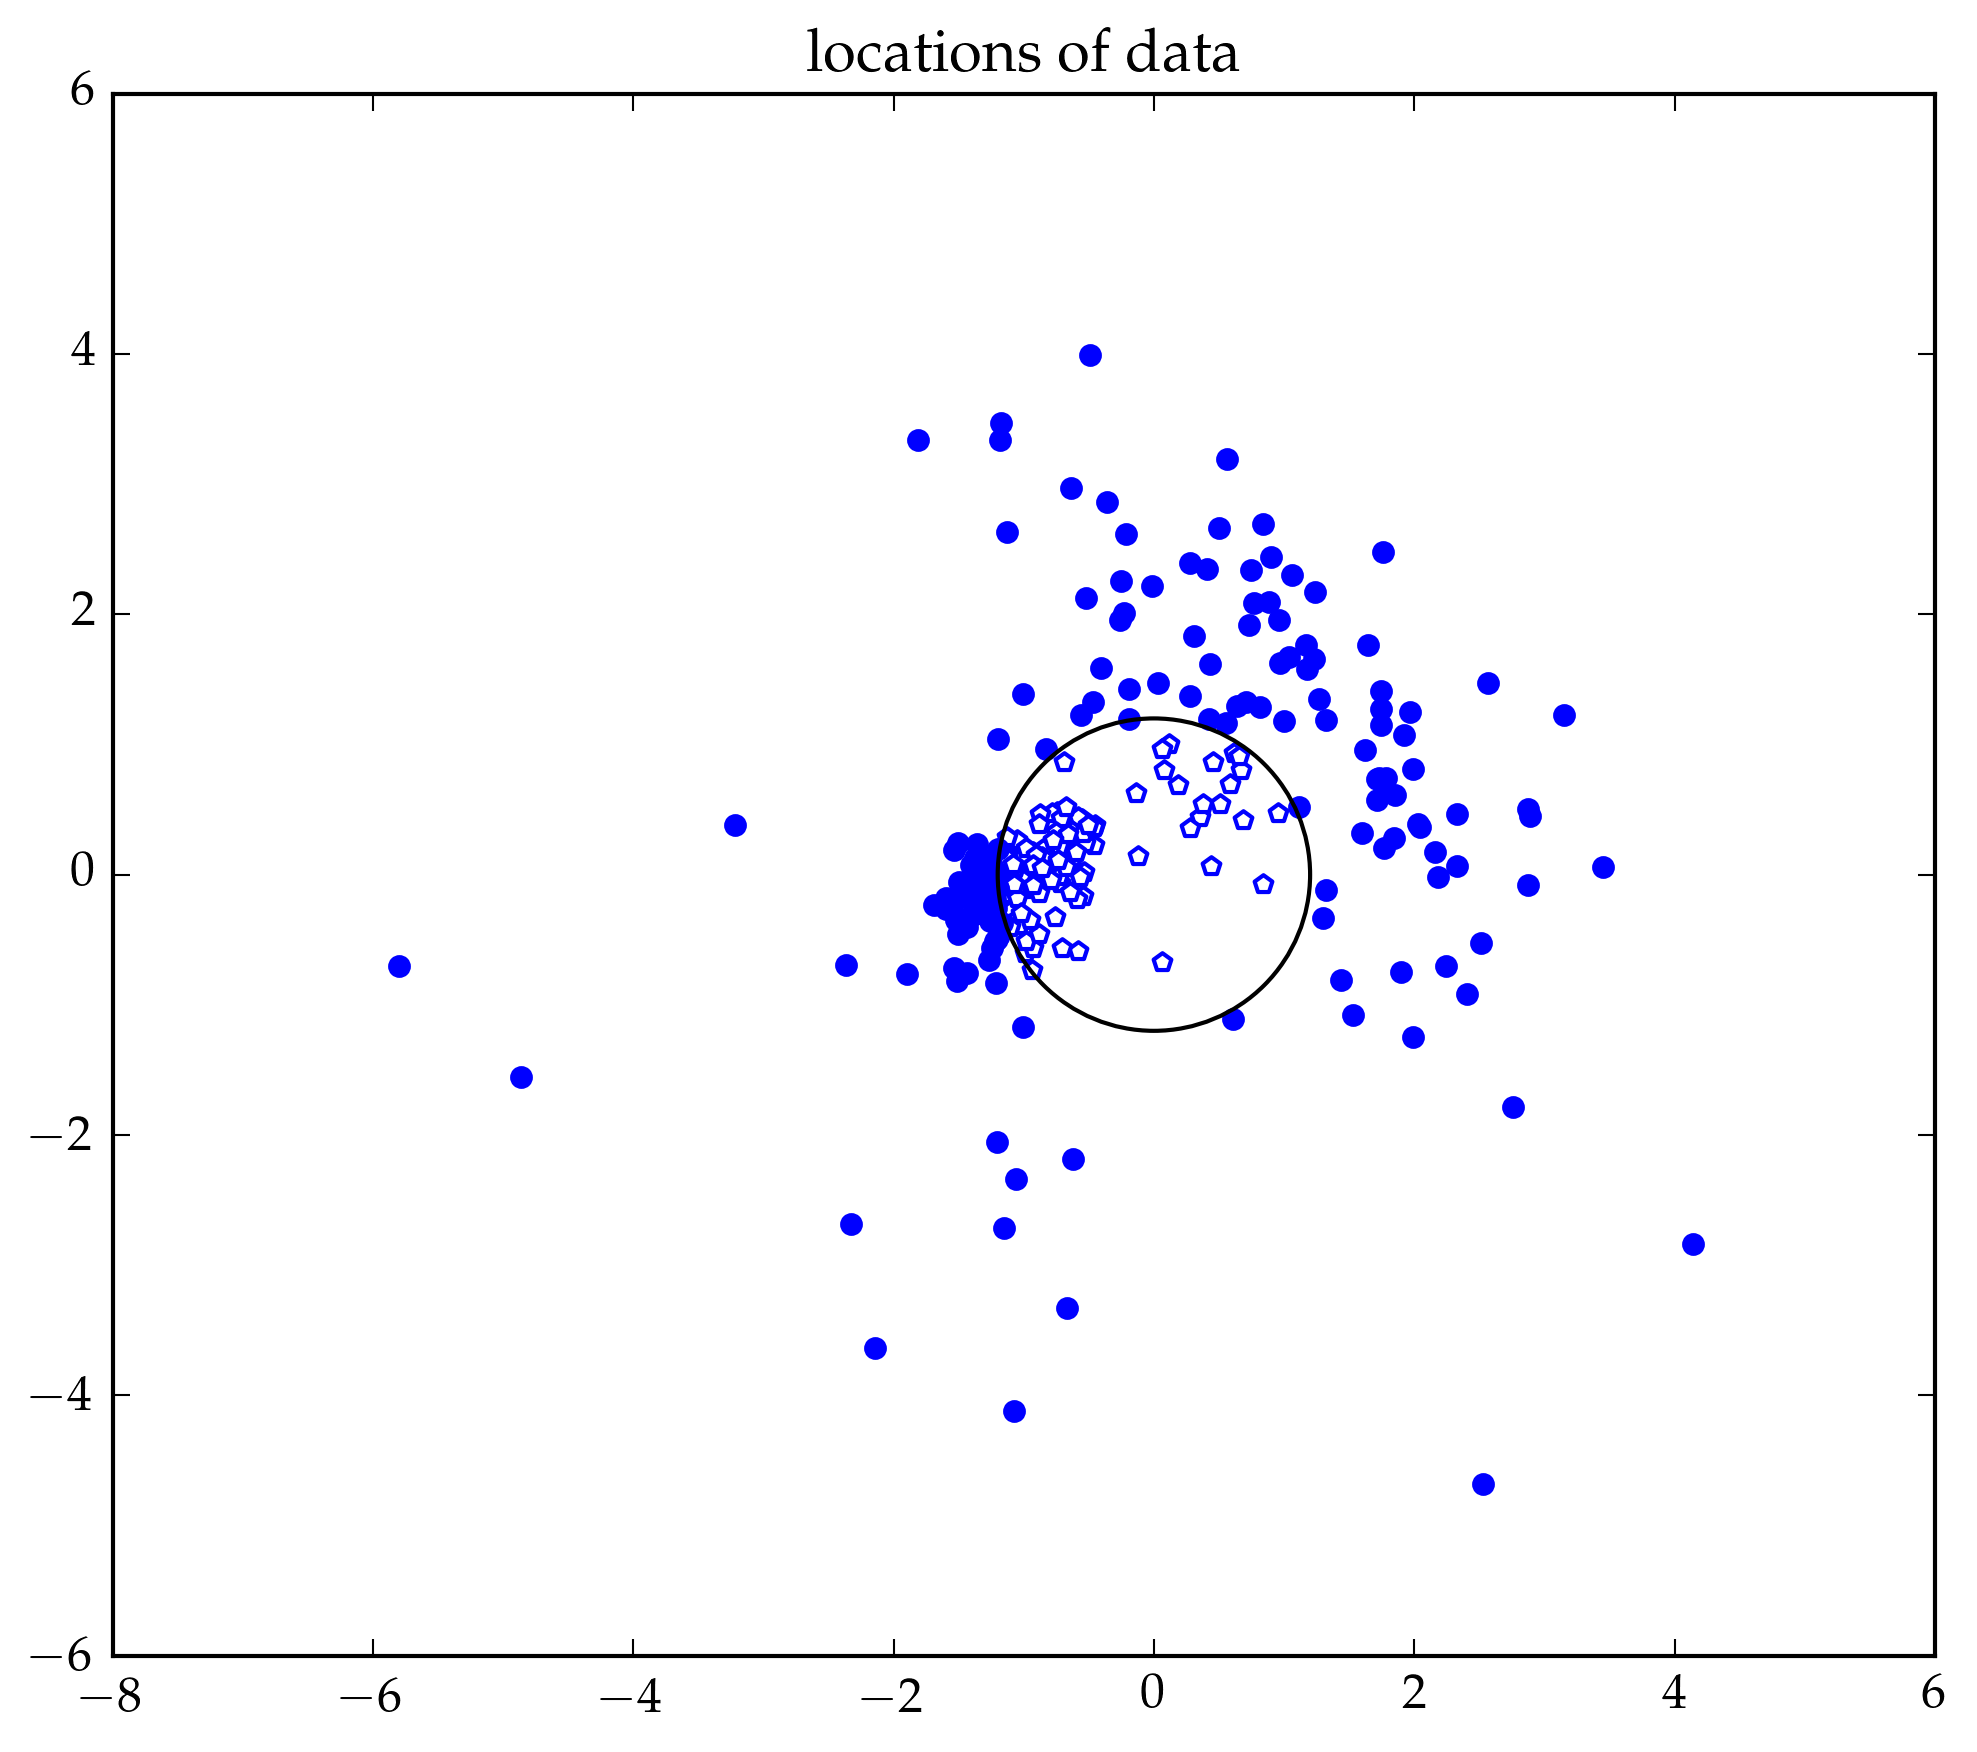

In [63]:
city = MultivariateNormal([-1.0,0.0], [[0.1,0.05] [0.05, 0.1]])
village = MultivariateNormal([1.0,1.0], [[1.0,-0.5] [-0.5, 1.0]])
countryside = MultivariateNormal([0.0, 0.0], [[4.0,0.0] [0.0, 4.0]])
X=[rand(city, 150) rand(village, 100) rand(countryside, 30)]
_,n = size(X)
r◫ = 1.2
inside = vec((X[1,:].^2 .+ X[2,:].^2) .< r◫^2)
plt.scatter(X[1,inside],X[2,inside], color="white", edgecolor="blue", marker="p")
plt.scatter(X[1,!inside],X[2,!inside], color="blue")
circle=plt.plt[:Circle]((0,0),r◫,color="black", fill=false)
plt.gca()[:add_artist](circle)
plt.gca()[:set_aspect]("equal")
plt.title("locations of data");

# Simulate data from GP

In [64]:
Lstar=1.0
σf_star=2.0
σy2_star=0.5
kern = SE(log(Lstar), log(σf_star))

Type: GaussianProcesses.SEIso, Params: [0.0,0.6931471805599453]


In [65]:
Σprior=GaussianProcesses.crossKern(X, kern)
μprior=zeros(n)
Σobs=copy(Σprior)
for i in 1:n
    Σobs[i,i] += σy2_star
end
prior=MultivariateNormal(μprior,Σobs)
Y=rand(prior)
;

In [66]:
α◫ = linspace(0,2π,100)
x1◫ = cos(α◫)*r◫
x2◫ = sin(α◫)*r◫
X◫ = [x1◫ x2◫]'
size(X◫)

(2,100)

# Inference

In [67]:
gp_fit_inside = GP(X[:,inside], Y[inside], MeanZero(), kern, log(σy2_star))
gp_fit_outside = GP(X[:,!inside], Y[!inside], MeanZero(), kern, log(σy2_star))
;

In [68]:
extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)

([-1.99041,-2.12482,-2.24756,-2.35678,-2.4505,-2.52662,-2.58299,-2.61767,-2.62906,-2.61615  …  -0.552067,-0.706376,-0.867976,-1.0341,-1.20205,-1.36936,-1.53375,-1.69323,-1.846,-1.99041],
100x100 Array{Float64,2}:
 0.171048   0.168003   0.163347   …  0.171831   0.172353   0.171048 
 0.168003   0.167227   0.164773      0.164363   0.167049   0.168003 
 0.163347   0.164773   0.16452       0.155618   0.160271   0.163347 
 0.157253   0.160739   0.162609      0.145885   0.152254   0.157253 
 0.149922   0.155261   0.159103      0.135459   0.143255   0.149922 
 0.141576   0.14851    0.154112   …  0.124622   0.133532   0.141576 
 0.132444   0.140678   0.147776      0.113637   0.12334    0.132444 
 0.12276    0.131974   0.140272      0.102737   0.112918   0.12276  
 0.112744   0.122614   0.131793      0.0921229  0.102484   0.112744 
 0.102605   0.112814   0.122552      0.0819559  0.0922271  0.102605 
 0.0925332  0.102783   0.112768   …  0.0723612  0.082307   0.0925332
 0.0826931  0.0927171  0.102

In [69]:
μpost = extrap◫_inside[1].-extrap◫_outside[1]
Σpost = extrap◫_inside[2]+extrap◫_outside[2]
;

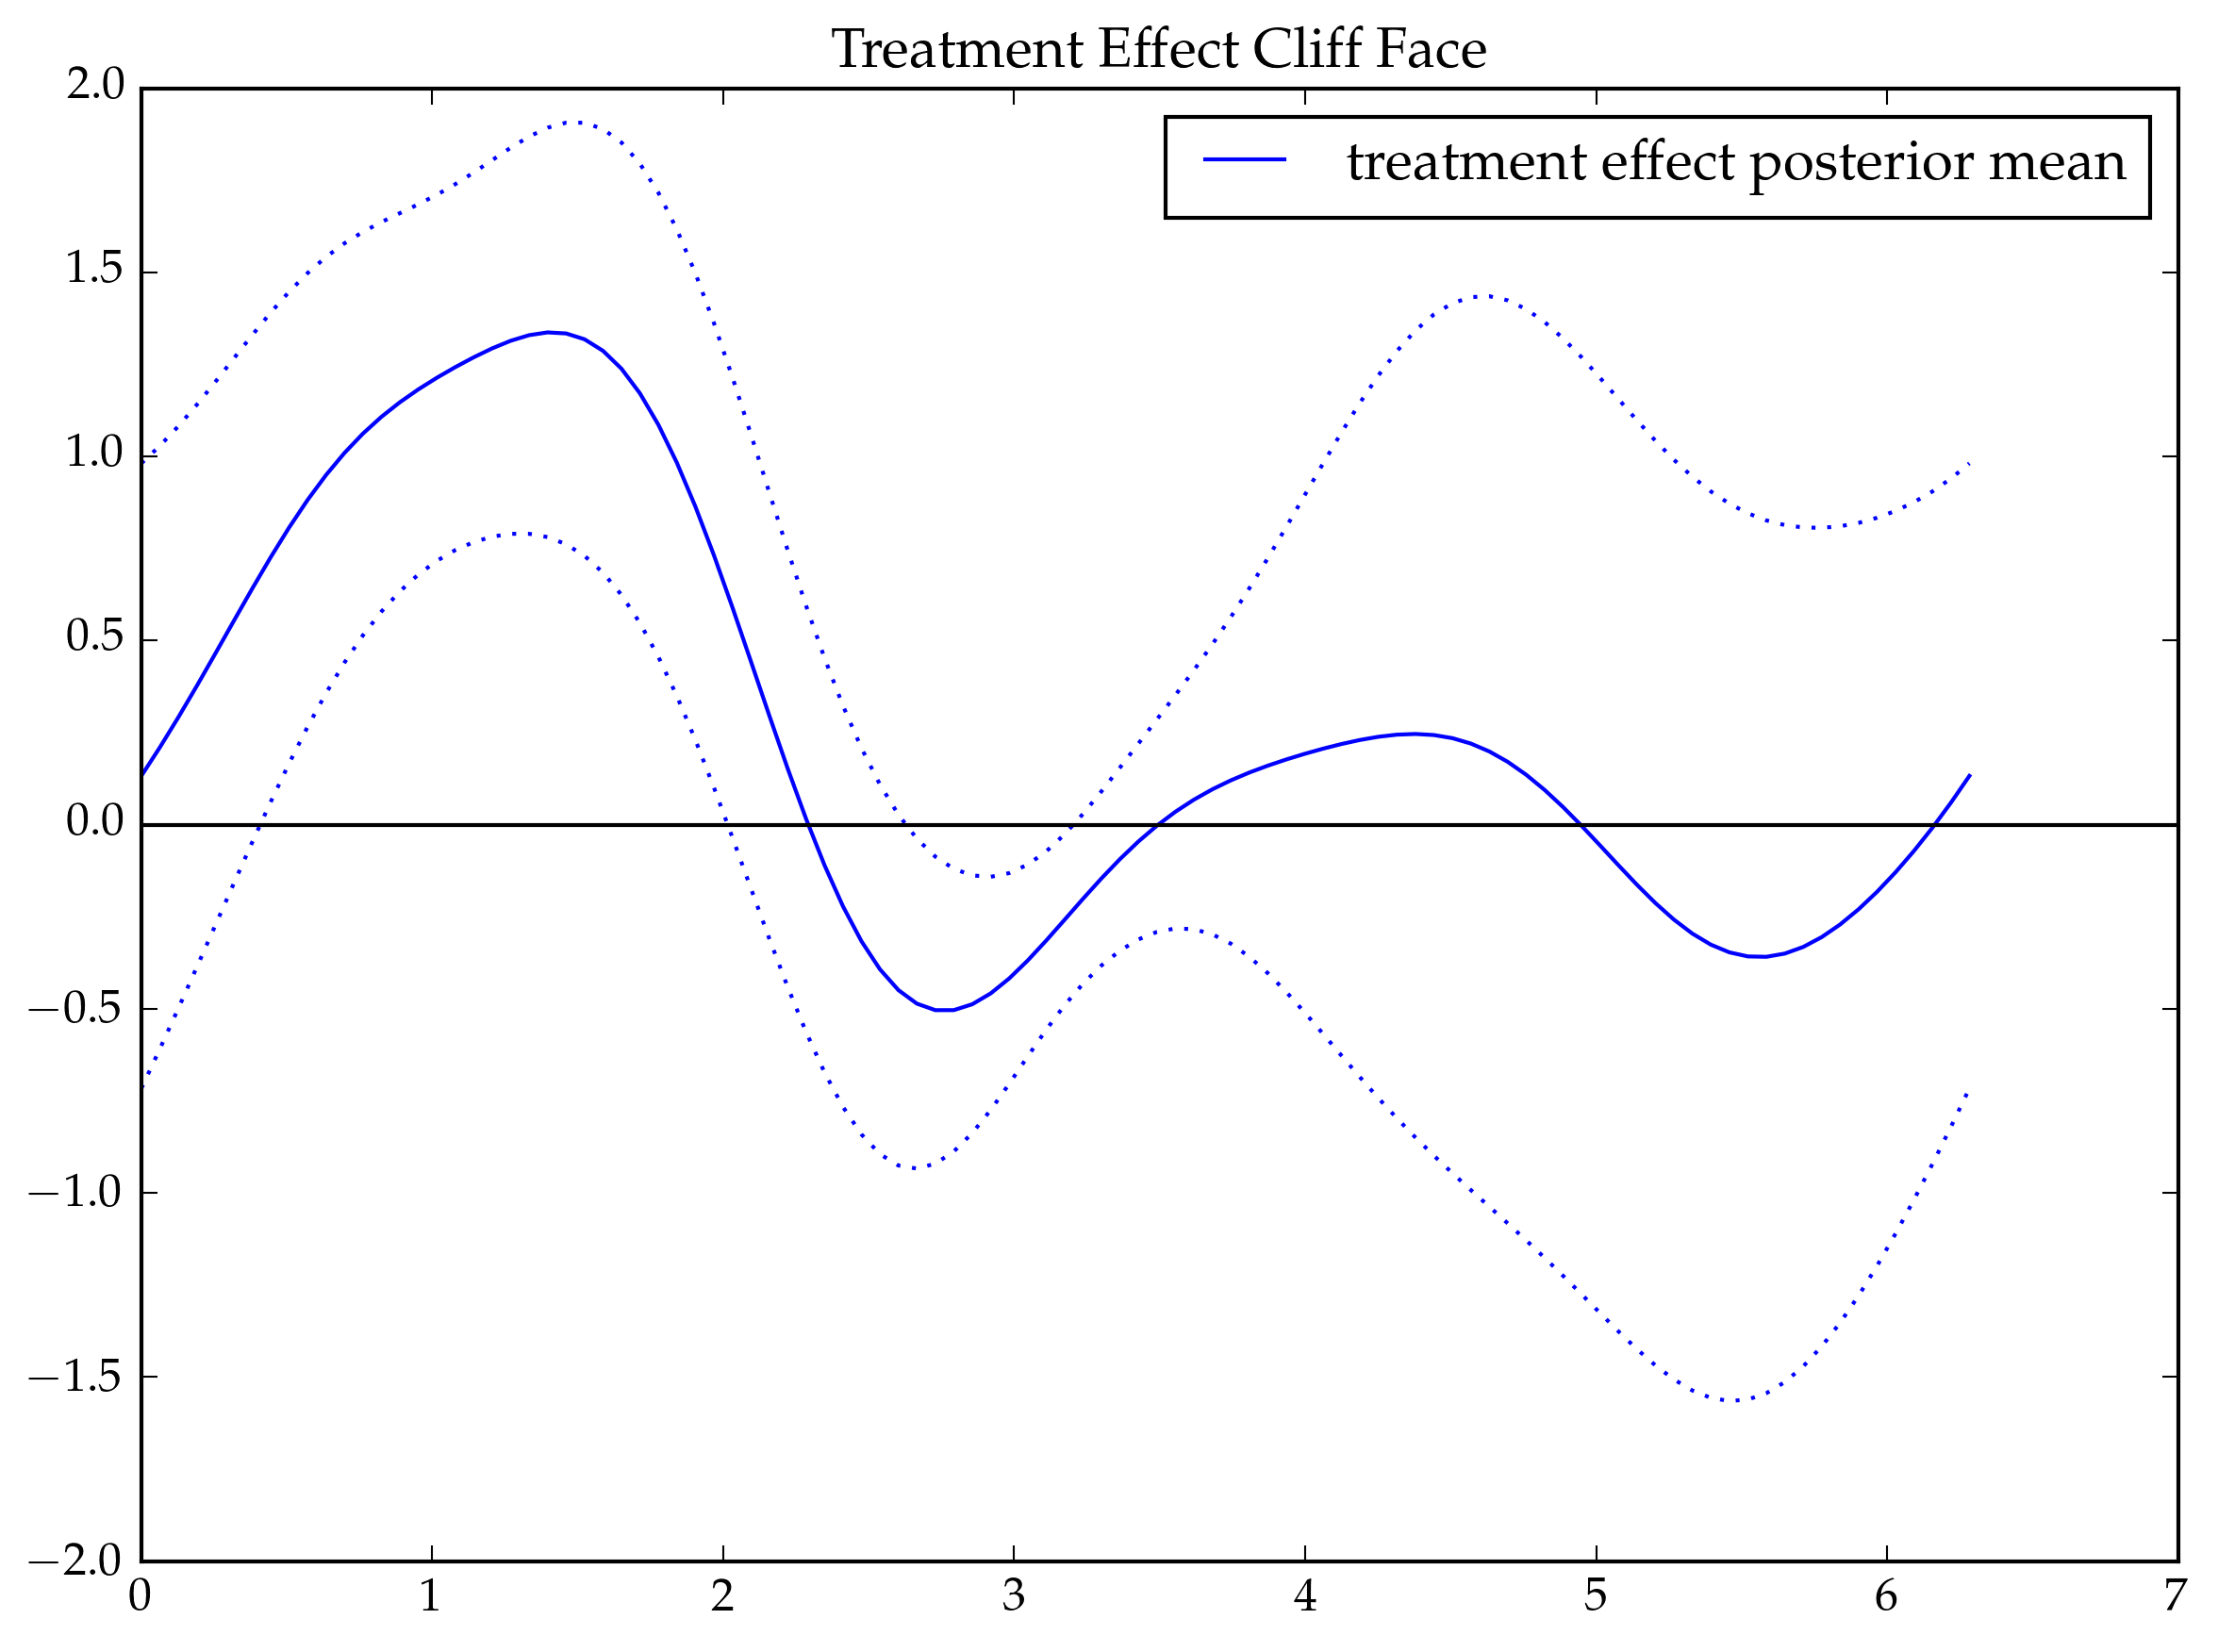

In [70]:
plt.plot(α◫, μpost, color="blue", label="treatment effect posterior mean")
plt.plot(α◫, μpost.+√diag(Σpost), color="blue", linestyle=":")
plt.plot(α◫, μpost.-√diag(Σpost), color="blue", linestyle=":")
plt.axhline(y=0, color="black")
plt.title("Treatment Effect Cliff Face")
plt.legend()
;

# Estimate mean treatment effect

The output of the 2GP model is a posterior distribution of $\tau_\discont \mid Y,X$. Conveniently, because it is the difference of two GPs, the posterior of $\tau$ is itself a GP. Concretely, we evaluate it on a grid along the boundary, and so the posterior is normally distributed with mean $\mu^{post}$ and $\Sigma^{post}$. 

Let's think a little bit about estimands and estimators. Two possibilities occur to me:
## Distance-averaged treatment effect
The first idea is to just average the posterior treatment effect along the boundary. 
\begin{align}
    \tau &= \frac{\oint_\discont \left. \tau(x) dx \right.}{\oint_\discont \left. dx \right.} \\
    \hat{\tau} &= \frac{\oint_\discont \left. \tau(x \mid Y,X) dx \right.}{\oint_\discont \left. dx \right.} \\
    \E\hat{\tau} &\approx \frac{\sum_{j=1}^n \left. \mu^{post}_j \right.}{n} \\
        &= \ones_n^\intercal \mu^{post} / n\\
    \V\hat{\tau} &\approx \frac{\sum_{i=1}^n \sum_{j=1}^n \Sigma^{post}_{ij}}{n^2} \\
        &= \ones_n^\intercal  \Sigma^{post} \ones_n / n^2
\end{align}
This assumes the chosen grid along the boundary is evenly sampled. Otherwise, we need to account for the space occupied by each point. We would encode this with $\delta$, a vector of the lengths of the boundary occupied by each point in $X_\discont$, and we would get
\begin{align}
    \E\hat{\tau} &\approx \frac{\delta^\intercal \mu^{post}}{\delta^\intercal \ones_n} \\
    \V\hat{\tau} &\approx \frac{\delta^\intercal \Sigma^{post} \delta}{\delta^\intercal \delta}
\end{align}

In [79]:
τhat = sum(μpost)/n
Vτhat = sum(Σpost)/n^2
Normal(τhat, √Vτhat)

Distributions.Normal(μ=0.09225357300208975, σ=0.13570034524684482)

In [82]:
1/sum(inv(Σpost))

0.0358664153785063

In [87]:
sum(Σpost)/n^2

0.018414583700112883

In [90]:
(0.1 + 1 + 10)/3^2

1.2333333333333334

In [91]:
1/(1/0.1 + 1/1 + 1/10)

0.0900900900900901

The problem with this is that the estimated variance $\V\hat{\tau}$ will blow up if there are sparsely populated segments of the boundary. It's the correct estimator for this estimand, but inference is essentially impossible if there are parts of the boundary where nobody lives (let's say the boundary goes through a big lake for example). This leads to the idea of downweighting the local treatment effects by their posterior variance.

## Inverse-variance weighted treatment effect
\begin{align}
    \E\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \mu^{post}}{\ones_n^T \Sigma^{-1} \ones_n} \\
    \V\hat{\tau} &= \frac{\ones_n^T \Sigma^{-1} \ones_n}{\del{\ones_n^T \Sigma^{-1} \ones_n}^2} \\
    &= 1 \big/ \del{\ones_n^T \Sigma^{-1} \ones_n}
\end{align}

In [80]:
denom = sum(inv(Σpost))
τhat = sum(inv(Σpost)*μpost) / denom
Vτhat = 1/denom
Normal(τhat, √Vτhat)

Distributions.Normal(μ=0.044468982359221164, σ=0.1893843060512309)

# Simulate under the null

Sensibly, since we are simulating from a null hypothesis, 0 is included in a 1$\sigma$ credible interval. Let's see how often that will be the case. To save ourselves some trouble, we'll keep the positions of the data fixed, so we can just simulate a new $Y$, thus leaving the covariance matrix unchanged.

In [73]:
function update_alpha!(gp::GP)
    m = GaussianProcesses.meanf(gp.m,gp.x)
    gp.alpha = gp.cK \ (gp.y - m)
end
function sim_null()
    Ystar = rand(prior)
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    denom = sum(inv(Σpost))
    τhat = sum(inv(Σpost)*μpost) / denom
    Vτhat = 1/denom
    return τhat/√Vτhat
end
eff_null = Float64[sim_null() for _ in 1:10000];

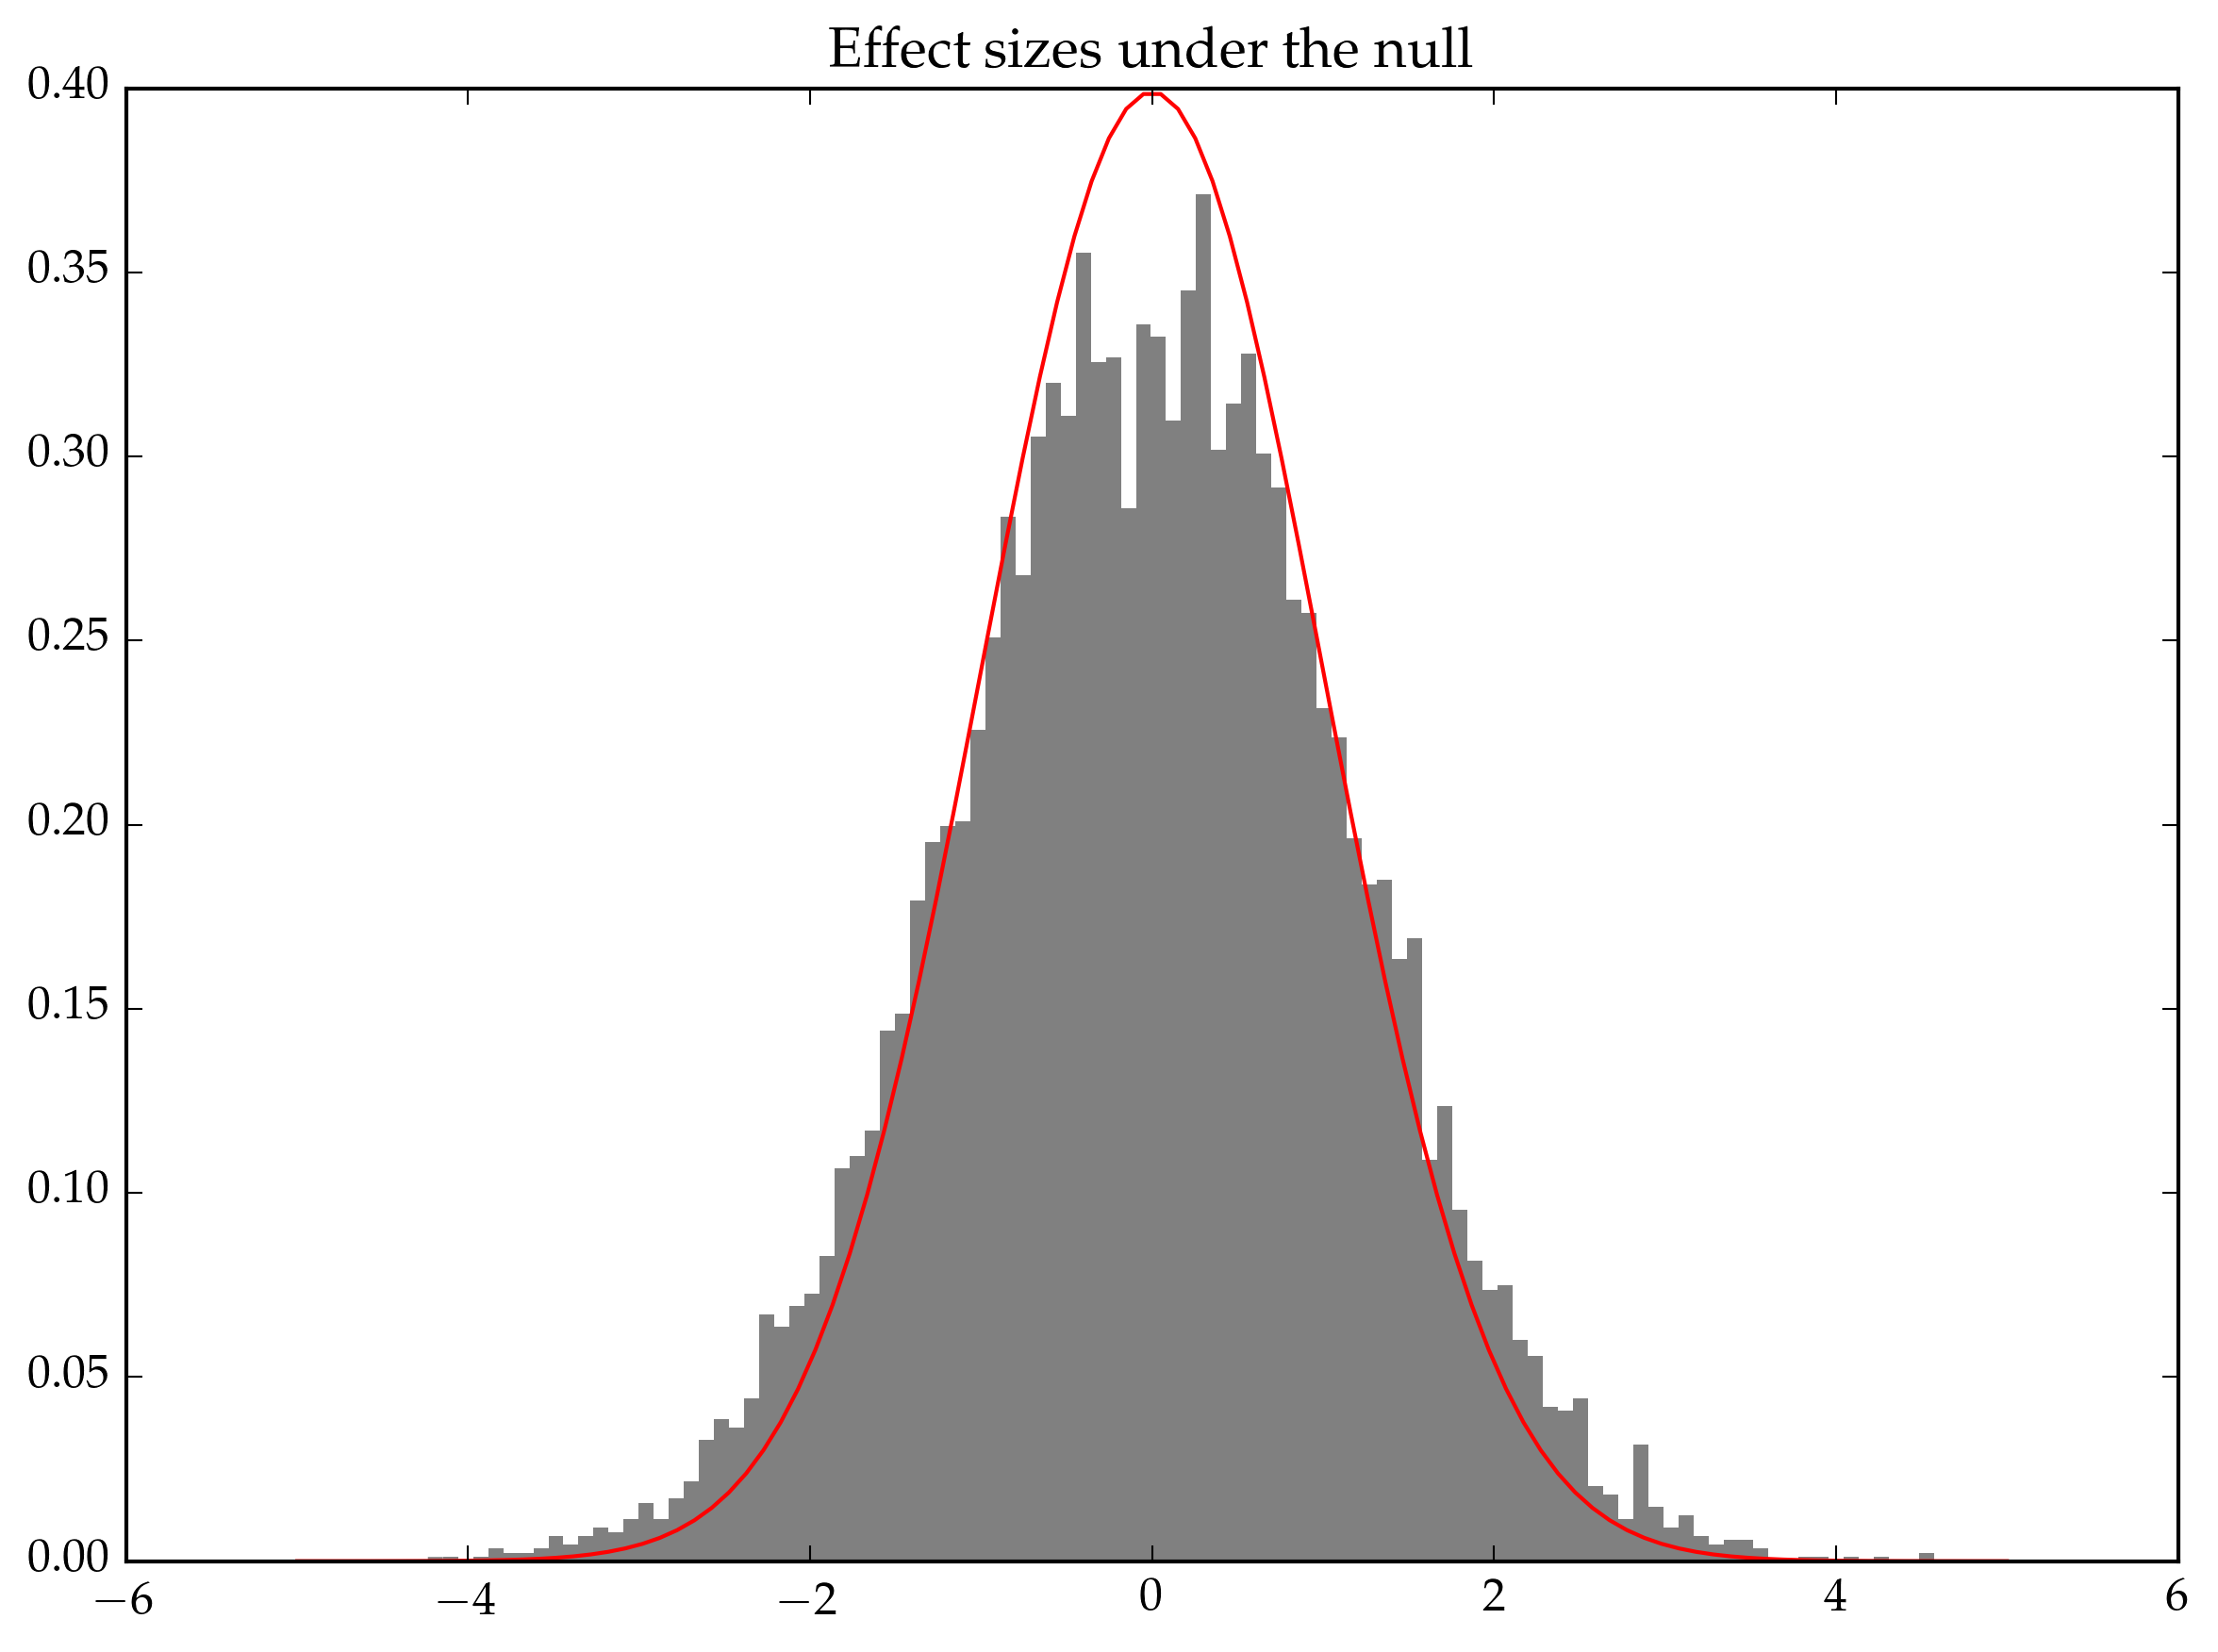

In [74]:
plt.plt[:hist](eff_null, bins=100, color="grey", edgecolor="none", normed=true)
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title("Effect sizes under the null")
;

Brilliant! The standardized effect $\E\hat{\tau} \big/ \sqrt{\V\hat{\tau}}$ is distributed as a standard normal (or at least pretty close). I was actually not expecting that to be the case.

# Power under an alternative

In [77]:
function sim_alt(τ::Float64)
    Ystar = rand(prior)
    Ystar[inside] .+= τ
    gp_fit_inside.y = Ystar[inside]
    gp_fit_outside.y = Ystar[!inside]
    update_alpha!(gp_fit_inside)
    update_alpha!(gp_fit_outside)
    extrap◫_inside = predict(gp_fit_inside, X◫; full_cov=true)
    extrap◫_outside = predict(gp_fit_outside, X◫; full_cov=true)
    μpost = extrap◫_inside[1].-extrap◫_outside[1]
    Σpost = extrap◫_inside[2]+extrap◫_outside[2]
    denom = sum(inv(Σpost))
    τhat = sum(inv(Σpost)*μpost) / denom
    Vτhat = 1/denom
    return τhat/√Vτhat
end
eff_alt = Float64[sim_alt(0.5) for _ in 1:10000];

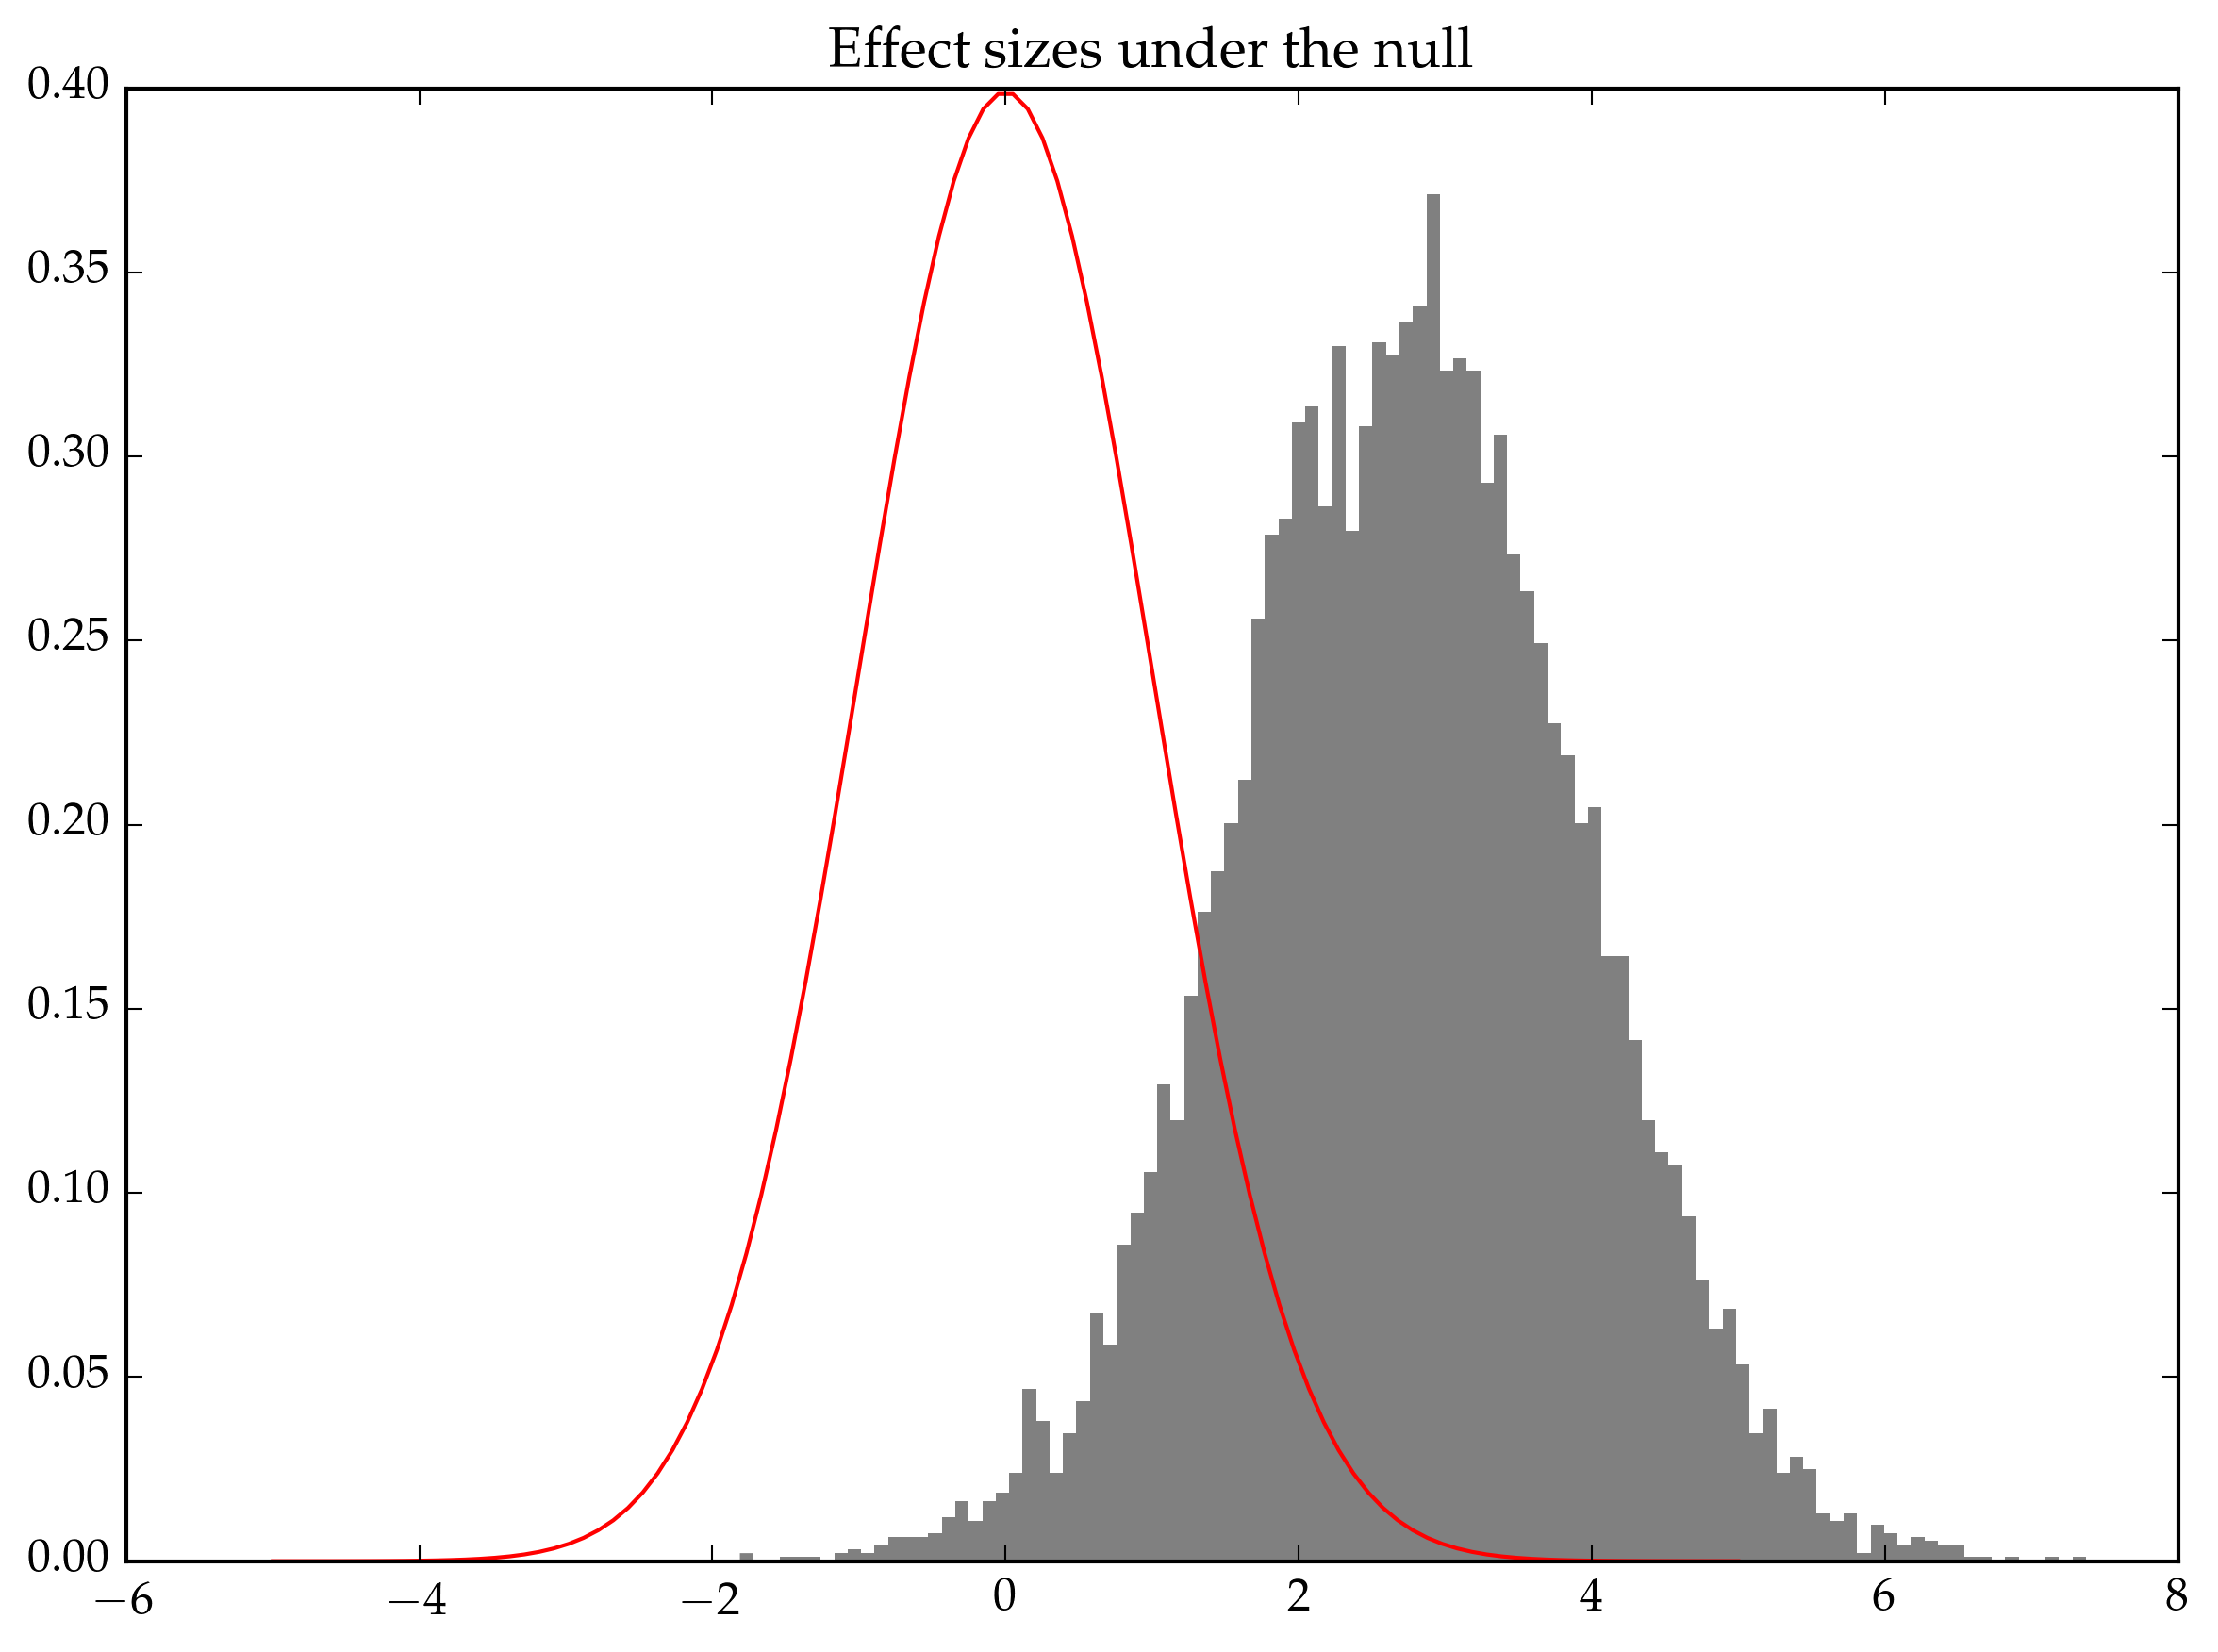

In [78]:
plt.plt[:hist](eff_alt, bins=100, color="grey", edgecolor="none", normed=true)
xx=linspace(-5.0,5.0,100)
plt.plot(xx, pdf(Normal(), xx), color="red", label=L"PDF of $\mathcal{N}(0,1)$")
plt.title("Effect sizes under the null")
;

Not too bad! This seems to be doing something sensible.